### Motivation

We wish to explore the effect of dimensionality on the probabilistic cluster assignments of GMMs. We start in 2 dimensions and create two clusters with a strong overlap and fit a GMM model to it. We demonstrate that there is a reasonably high probability for certain points to belong to both clusters, due to the overlap. Then we will increase the dimensionality and show how this overlap falls apart, though the clusters are created in the same way. In this high dimensional scenario, the GMM is 100% sure about every point in each cluster and we lose the 'soft clustering' strength of the GMM.

First we create two clusters with strong overlap - i.e. $\mu_1 = (-0.5,-0.5)$ and $\mu_2 = (0.5,0.5)$, and both with a covariance matrix $C=I$ as shown below.

In [1]:
import matplotlib
#matplotlib.use('nbagg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import linalg
from sklearn.mixture import GaussianMixture

In [3]:
def generate_clusters(dims, num_pts=1000):
    clust1 = np.random.multivariate_normal([-0.5]*dims, np.eye(dims), num_pts)
    clust2 = np.random.multivariate_normal([0.5]*dims, np.eye(dims), num_pts)
    return [clust1, clust2]

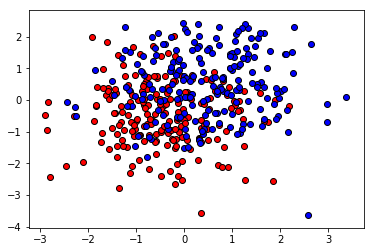

In [4]:
c1, c2 = generate_clusters(2,200)
fig, ax = plt.subplots()
ax.scatter(c1[:,0], c1[:,1], c='r', edgecolor='k')
ax.scatter(c2[:,0], c2[:,1], c='b', edgecolor='k')
plt.show()

Next we fit a 2 mode Gaussian Mixture Model to the data set and examine the results.

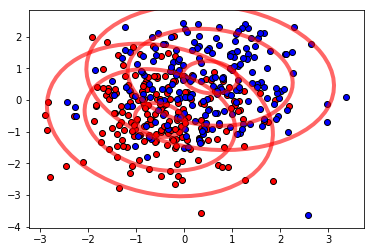

In [5]:
gmm = GaussianMixture(2).fit(np.append(c1,c2,0))

fig, ax = plt.subplots()
ax.scatter(c1[:,0], c1[:,1], c='r', edgecolor='k')
ax.scatter(c2[:,0], c2[:,1], c='b', edgecolor='k')

for mu, cov in zip(gmm.means_,gmm.covariances_):
    w,v = linalg.eigh(cov)
    w = 2*np.sqrt(2)*np.sqrt(w)
    angle = np.arctan(v[0,1] / v[0,0])
    for std in [0.4,1.2,1.8]:
        ellipse = mpatches.Ellipse(mu, std*w[0], std*w[1], angle*(180/np.pi), edgecolor='r', alpha=0.6, fill=False, lw=4)
        ax.add_patch(ellipse)
plt.show()

Let us examine the confidence of the GMM in cluster assignment for each cluster. We start by passing the entire first cluster (all of the red points) through the GMM and get the probability that each point belongs to either of the GMM modes.

In [6]:
gmm.predict_proba(c1)[:10]

array([[ 0.23295744,  0.76704256],
       [ 0.45874256,  0.54125744],
       [ 0.50135367,  0.49864633],
       [ 0.94870448,  0.05129552],
       [ 0.0287505 ,  0.9712495 ],
       [ 0.01456836,  0.98543164],
       [ 0.26314386,  0.73685614],
       [ 0.24501752,  0.75498248],
       [ 0.29408344,  0.70591656],
       [ 0.01965745,  0.98034255]])

As we see, the first point is is described mostly by the red Gaussian, 76% with only 23% by the blue one. However, there is clearly a very strong misclassification with the 4th point! That is said to be described with 95% of the blue Gaussian! That point must be one of the ones in the top right... Let's check.

In [7]:
c1[3]

array([-0.22448263,  2.02516733])

Yes, that point is about the furthest away from the red cluster. To summarize all of these probabilities with a single number, we will use their mean.

In [8]:
gmm.predict_proba(c1).mean(0)

array([ 0.27632339,  0.72367661])

So in 2 dimensions, the overlap seems to be quite noticable. Roughly 28% of the red cluster can be described by the blue Gaussian. We see even more overlap, 32%, with the blue cluster described by the red Gaussian.

In [9]:
gmm.predict_proba(c2).mean(0)

array([ 0.67777016,  0.32222984])

Let us examine what happens as we incrementally move up in dimensions. We will plot the probability of of the red points belonging to cluster 1 (solid line) and 1 minus the probability (dashed line) as a function of the dimension. We also add the distance between clusters in aqua and its scale is shown on the right vertical axis.

In [9]:
c1_sph = [] # Sphericity of cluster 1
c2_sph = [] # Sphericity of cluster 2
dist = [] # Distance between Gaussians
ll = [] # Loglikelihood of gmm
bic = [] # Bayesian Information Criterion of current model
c1_probs = [] # GMM predictions for cluster 1
c2_probs = [] # GMM predictions for cluster 2
for dim in np.arange(3,40):
    c1, c2 = generate_clusters(dim,3000)
    tot_data = np.append(c1,c2,0)
    gmm = GaussianMixture(2).fit(tot_data)
    dist.append(np.linalg.norm(gmm.means_))
    ll.append(gmm.lower_bound_)
    c1_eigs = np.linalg.eig(gmm.covariances_[0])[0]
    c2_eigs = np.linalg.eig(gmm.covariances_[1])[0]
    c1_sph.append((c1_eigs/c1_eigs.max()).std())
    c2_sph.append((c2_eigs/c2_eigs.max()).std())
    bic.append(gmm.bic(tot_data))
    c1_probs.append(np.sort(gmm.predict_proba(c1).mean(0)))
    c2_probs.append(-np.sort(-gmm.predict_proba(c2).mean(0)))

In [10]:
c1_probs = np.array(c1_probs)
c2_probs = np.array(c2_probs)

In [11]:
fig, ax = plt.subplots()
# Cluster 1
ax.plot(c1_probs[:,0], ls='dashed', c='r')
ax.plot(c1_probs[:,1], ls='solid', c='r')
# Cluster 2
#ax.plot(c2_probs[:,0], ls='dashed', c='b')
#ax.plot(c2_probs[:,1], ls='solid', c='b')
ax.set(ylim=[0,1], ylabel='Responsibility of Cluster 1', xlabel='Dimensions')
ax2 = ax.twinx()
ax2.set(ylabel='Distance between Clusters')
ax2.plot(dist)

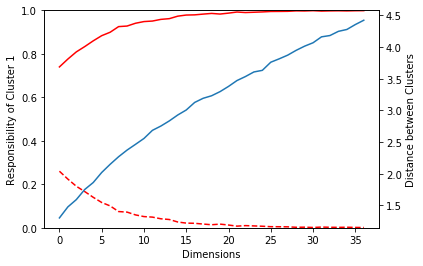

In [12]:
plt.show()

As we see, already by dimension 35 the Gaussian mixture model is nearly 100% certain of the cluster assignments. The heavy overlap from before is gone as we can see by the distance between the means. The distance is nearly 4.5 units and each cluster was originall only given a stadard deviation of one in each direction. So in 400 dimensions, as our EEG data is, there will most certainly be no overlap, and we indeed observe that to be the case with the results of our GMM experiments.